In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [2]:
predictor = TimeSeriesPredictor.load('weekly_ACT_predictor')

In [3]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0


In [4]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']
print(df_IT.shape)

(172, 13)


In [5]:
# Drop ACT04 column
df_IT = df_IT.drop(columns=['ACT04'])

In [6]:
# Remove idem_id column and target column
df_IT = df_IT.drop(columns=['item_id', 'target'])
df_IT.head()

,timestamp,ACT01,ACT03,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
348,2019-12-30,1228.0,87.0,195.0,188.0,32.0,1817.0,1255.0,2811.0,0.0
349,2020-01-06,87.0,63.0,5.0,8.0,0.0,0.0,0.0,227.0,0.0
350,2020-01-13,161.0,10.0,14.0,0.0,49.0,1.0,0.0,467.0,0.0
351,2020-01-20,437.0,143.0,86.0,67.0,110.0,0.0,0.0,98.0,0.0
352,2020-01-27,403.0,457.0,178.0,108.0,48.0,7.0,0.0,269.0,0.0


In [7]:
# Trasforma le colonne ACT in una singola colonna item_id e i valori corrispondenti in una colonna target
df_IT = df_IT.melt(id_vars=["timestamp"], var_name="item_id", value_name="target")

# Ordina il DataFrame per il timestamp
df_IT.sort_values(by="timestamp", inplace=True)

# Visualizza il DataFrame trasformato
df_IT.head(10)

,timestamp,item_id,target
0,2019-12-30,ACT01,1228.0
172,2019-12-30,ACT03,87.0
1376,2019-12-30,ACT44,0.0
1032,2019-12-30,ACT17,1255.0
344,2019-12-30,ACT07,195.0
688,2019-12-30,ACT13,32.0
860,2019-12-30,ACT15,1817.0
1204,2019-12-30,ACT32,2811.0
516,2019-12-30,ACT09,188.0
689,2020-01-06,ACT13,0.0


In [8]:
# Drop row where item_id is ACT17 and ACT44
df_IT = df_IT[df_IT['item_id'] != 'ACT17']
df_IT = df_IT[df_IT['item_id'] != 'ACT44']

df_IT.shape

(1204, 3)

In [9]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [10]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

,,target
item_id,timestamp,
ACT01,2019-12-30,1228.0
ACT03,2019-12-30,87.0
ACT07,2019-12-30,195.0
ACT13,2019-12-30,32.0
ACT15,2019-12-30,1817.0


In [11]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

,,target
item_id,timestamp,
ACT01,2022-05-02,788.0
ACT15,2022-05-02,515.0
ACT07,2022-05-02,396.0
ACT13,2022-05-02,111.0
ACT09,2022-05-02,30.0


In [12]:
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
ACT01   2022-05-02  782.697311   92.435401  354.730491  485.174526   
        2022-05-09  322.033370  -46.523209   94.176774  153.667904   
        2022-05-16  348.060985  -28.623437  109.094542  182.155355   
        2022-05-23  478.663296  -42.442665  148.786940  256.054383   
        2022-05-30  747.500359  153.956439  338.045557  488.009787   

                           0.4         0.5         0.6          0.7  \
item_id timestamp                                                     
ACT01   2022-05-02  657.303163  782.697311  937.190059  1074.419009   
        2022-05-09  229.787910  322.033370  409.874392   515.337102   
        2022-05-16  258.472216  348.060985  452.065646   543.437343   
        2022-05-23  355.790850  478.663296  623.956427   759.129891   
        2022-05-30  626.277506  747.500359  879.317973  1038.285070   

                            0.8          0.9  
item_id timestamp                             
ACT01   2022-05-02  1293.447410  1635.240268  
        2022-05-09   766.093207  1013.913524  
        2022-05-16   713.262129   974.701691  
        2022-05-23   931.279304  1223.984982  
        2022-05-30  1233.801761  1491.731856

In [13]:
predictor.leaderboard(test_data)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,DeepAR,-0.495605,-0.737909,0.314758,0.155191,395.374657,9
1,WeightedEnsemble,-0.503012,-0.664949,1.085662,0.700675,7.100072,12
2,PatchTST,-0.523626,-0.718648,0.039841,0.017165,186.326894,11
3,DirectTabular,-0.588139,-0.758618,0.235070,0.115084,3.914985,8
4,TemporalFusionTransformer,-0.592977,-0.710975,0.083964,0.039981,608.795976,10
5,NPTS,-0.604805,-0.862031,0.040508,0.062556,0.238079,3
6,AutoARIMA,-0.671024,-0.874053,27.416671,2.490987,33.856923,6
7,AutoETS,-0.689329,-0.898196,62.280559,0.041029,36.449646,4
8,CrostonSBA,-0.722997,-0.868434,10.579505,0.031306,16.494350,2
9,DynamicOptimizedTheta,-0.735832,-0.872637,35.746151,0.068920,26.025593,5


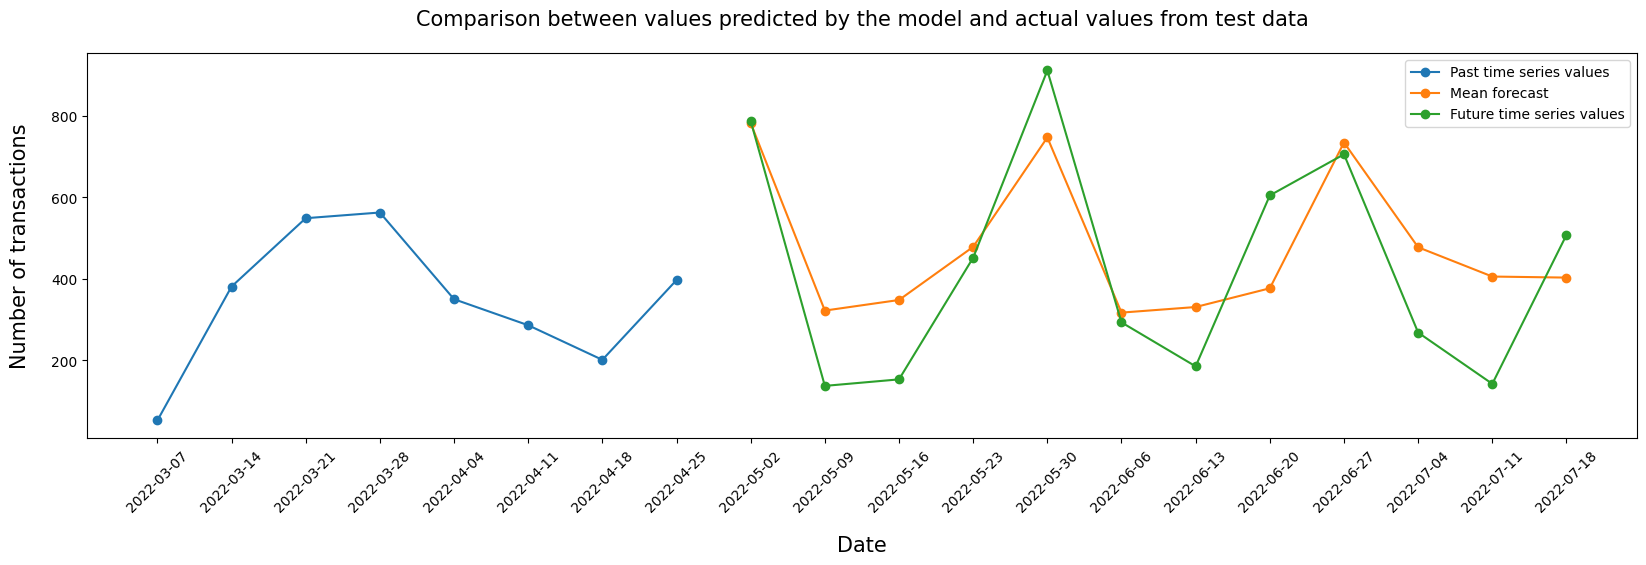

In [14]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

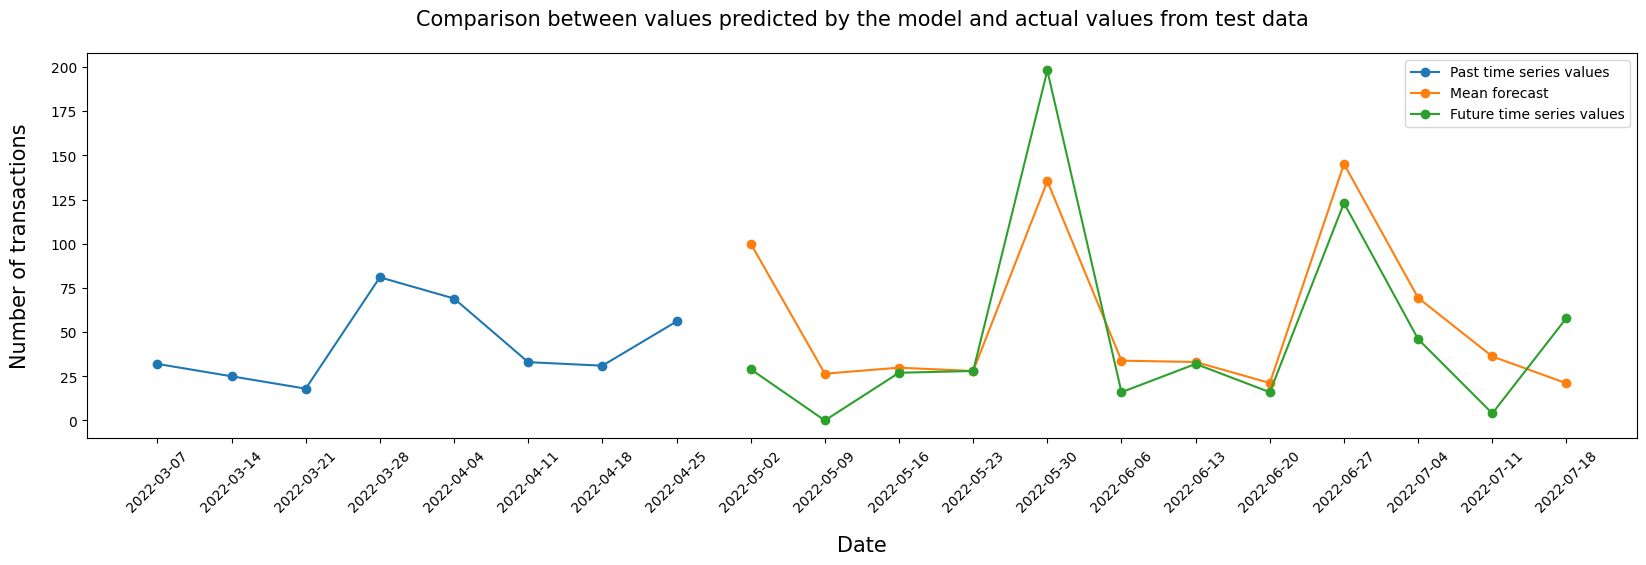

In [15]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT03"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

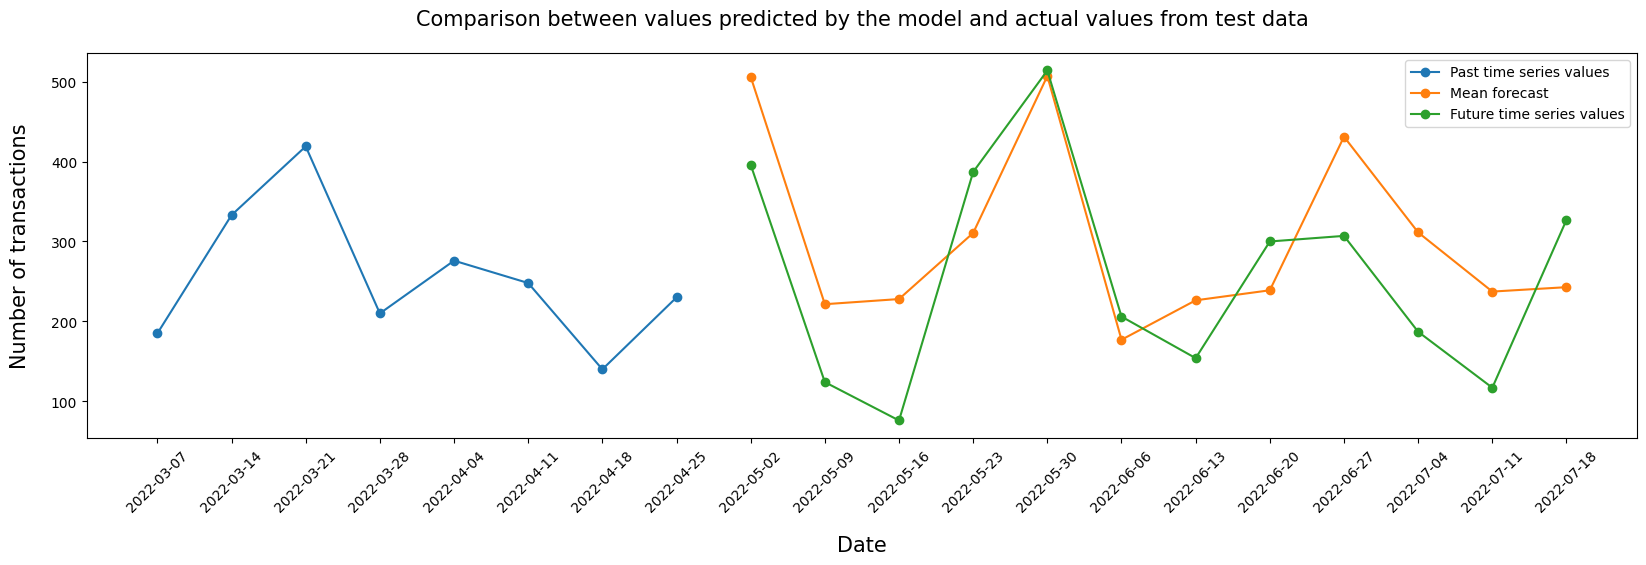

In [16]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT07"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

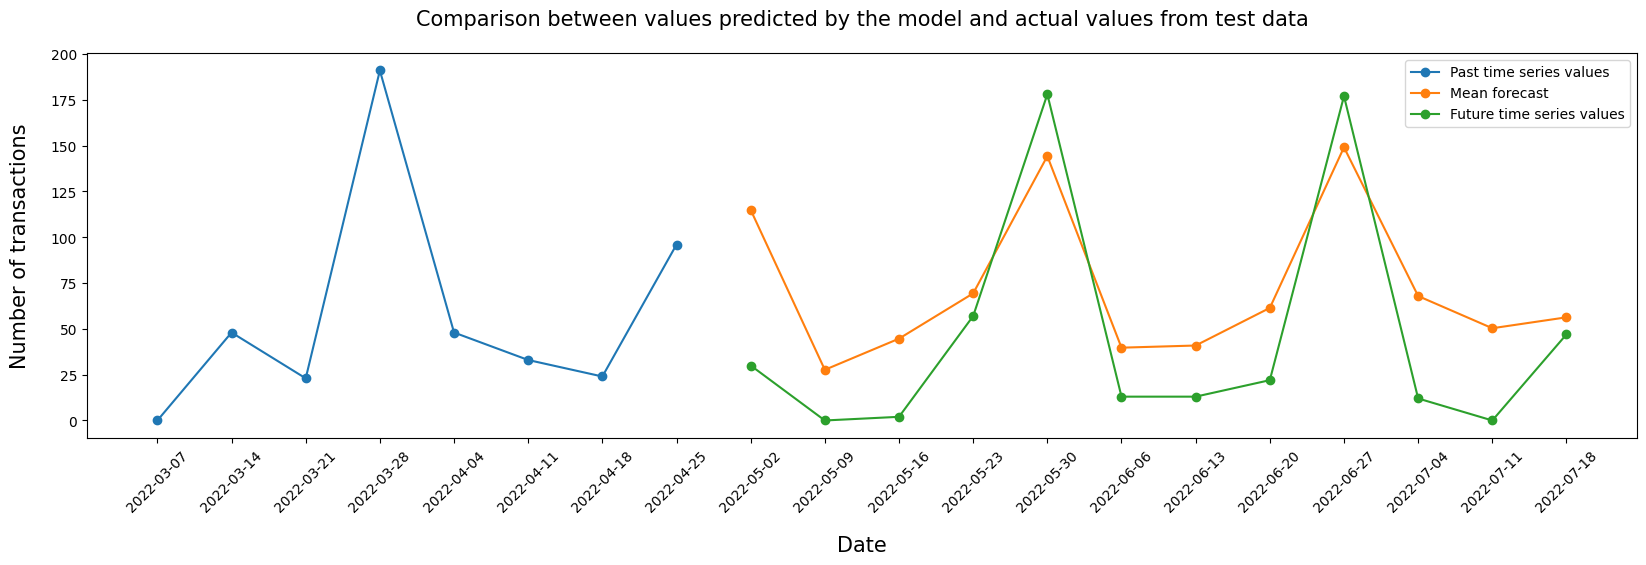

In [17]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT09"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

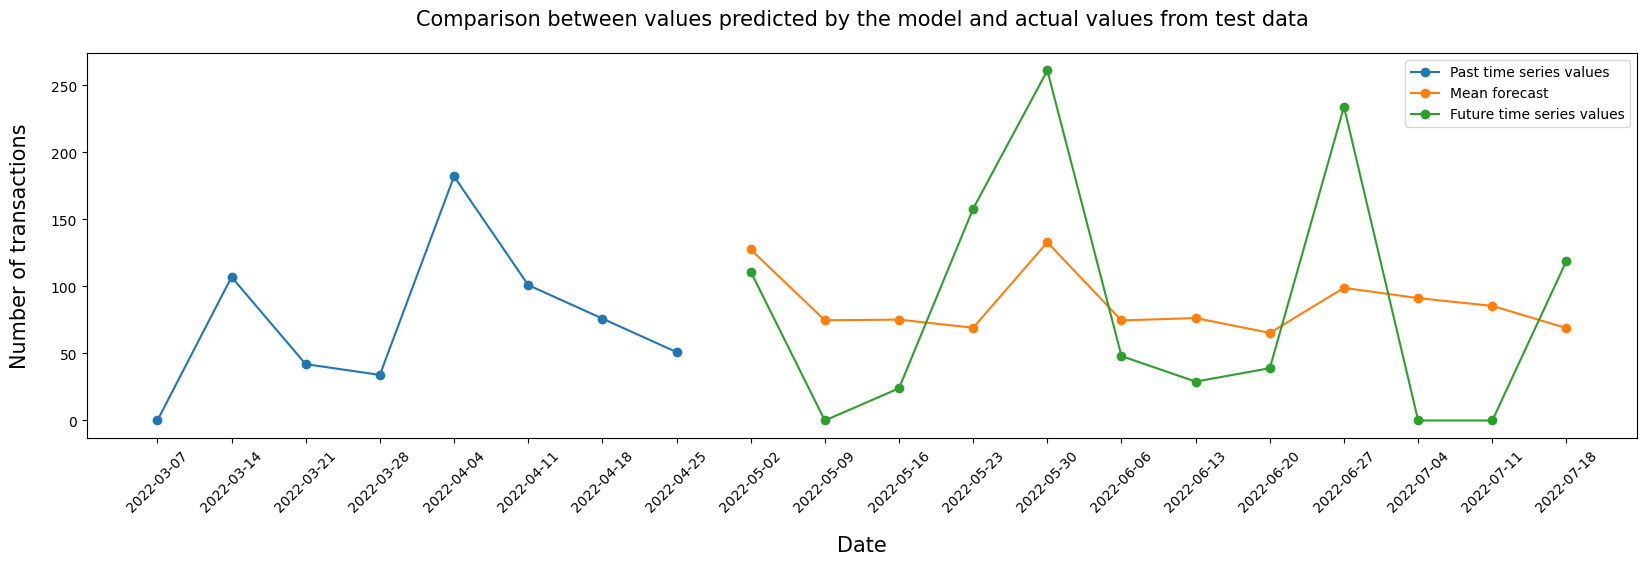

In [18]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT13"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

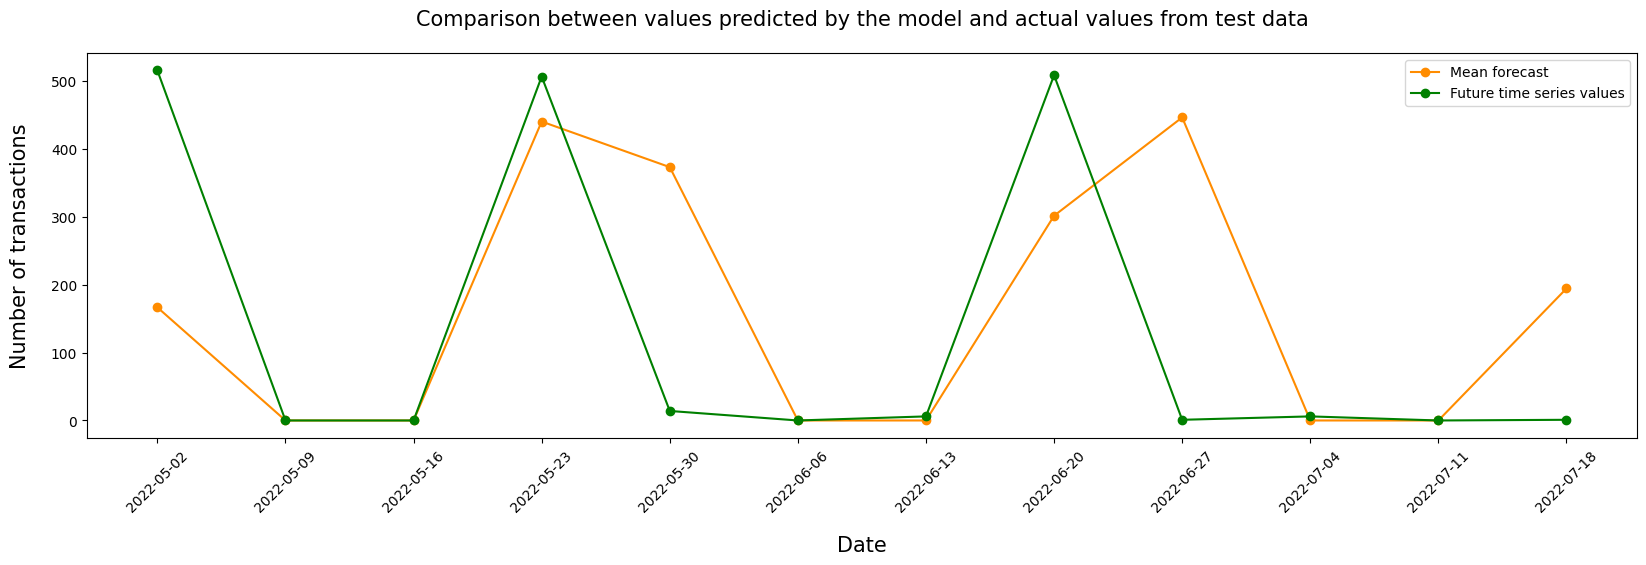

In [32]:
import numpy as np

# Set negative values of y_pred["mean"] to 0
y_pred_non_negative = np.maximum(y_pred["mean"], 0)

plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT15"
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for future
future_ticks = range(len(all_dates))

plt.plot(future_ticks, y_pred_non_negative, label="Mean forecast", color="darkorange", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", color="green", marker='o', linestyle='-')

# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()


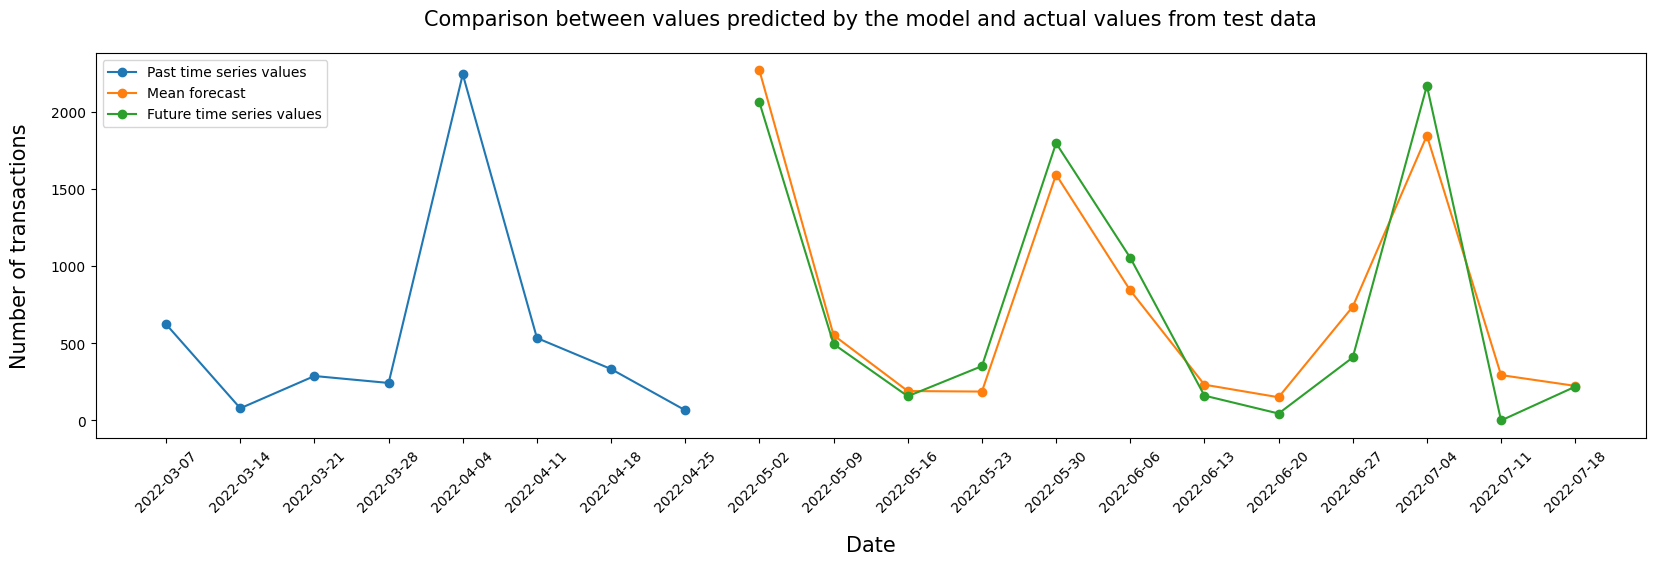

In [20]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT32"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()